In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import rescale, resize, radon, iradon
from skimage.filters import gaussian
import scipy
from scipy.signal import argrelextrema
from scipy.interpolate import CubicSpline
from scipy.optimize import root, leastsq
from PIL import Image
import sys
from utils import add_noise, snr_calc, DC_and_SYM
import h5py

/raid/home/everett/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/raid/home/everett/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [11]:
#h_sino = h5py.File('./sinograms/tomo_00001/tomo_00001.h5', 'r')
h_sino = h5py.File('./sinograms/tomo_00064_to_00067/tomo_00067.h5', 'r')
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))
h_sino.visititems(print_attrs)
data = h_sino['/exchange/data'][()]
theta = h_sino['/exchange/theta']
print(theta)

exchange
exchange/data
    units: b'counts'
    axes: b'theta:y:x'
    description: b'transmission'
exchange/data_dark
    units: b'counts'
    axes: b'theta_dark:y:x'
exchange/data_white
    units: b'counts'
    axes: b'theta_white:y:x'
exchange/theta
    units: b'degrees'
exchange/title
implements
measurement
measurement/instrument
measurement/instrument/acquisition
measurement/instrument/acquisition/comment
measurement/instrument/acquisition/mode
measurement/instrument/detector
measurement/instrument/detector/x_actual_pixel_size
    units: b'microns'
measurement/instrument/detector/y_actual_pixel_size
    units: b'microns'
measurement/instrument/monochromator
measurement/instrument/monochromator/energy
    units: b'keV'
measurement/instrument/source
measurement/instrument/source/beamline
measurement/instrument/source/current
    units: b'mA'
measurement/instrument/source/datetime
measurement/instrument/source/mode
measurement/instrument/source/name
measurement/sample
measurement/sam

In [4]:
'''
imshape = 512
im = (imshape,imshape)
offset = 0#int(imshape/10)+300
posa = int(imshape/2)-int(512/2)+offset
posb = int(imshape/2)+int(512/2)+offset


#Load Shepp Logan Phantom
slp = np.asarray(plt.imread('./pictures/Shepp-Logan_Phantom.tif')[:,:], dtype= float)

#Create space for offsetting phantom
phantom=np.zeros(im)

if posa > phantom.shape[0] or posb>phantom.shape[1]:
    phantom = slp[len(slp)-offset:len(slp)+offset,len(slp)-offset:len(slp)+offset]
else:
    phantom[posa:posb,posa:posb] = slp

phantom = slp[int(512/2)-int(imshape/2):int(512/2)+int(imshape/2),int(512/2)-int(imshape/2):int(512/2)+int(imshape/2)]
#number_angles = 1000
'''

"\nimshape = 512\nim = (imshape,imshape)\noffset = 0#int(imshape/10)+300\nposa = int(imshape/2)-int(512/2)+offset\nposb = int(imshape/2)+int(512/2)+offset\n\n\n#Load Shepp Logan Phantom\nslp = np.asarray(plt.imread('./pictures/Shepp-Logan_Phantom.tif')[:,:], dtype= float)\n\n#Create space for offsetting phantom\nphantom=np.zeros(im)\n\nif posa > phantom.shape[0] or posb>phantom.shape[1]:\n    phantom = slp[len(slp)-offset:len(slp)+offset,len(slp)-offset:len(slp)+offset]\nelse:\n    phantom[posa:posb,posa:posb] = slp\n\nphantom = slp[int(512/2)-int(imshape/2):int(512/2)+int(imshape/2),int(512/2)-int(imshape/2):int(512/2)+int(imshape/2)]\n#number_angles = 1000\n"

(350, 450)
0.8290004505732286


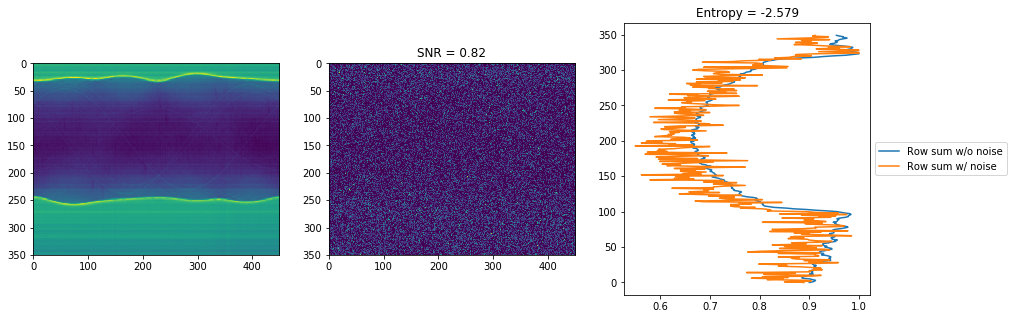

In [12]:
'''
Circle = False
theta = np.linspace(0., 360, number_angles, endpoint=False)

sinogram = radon(phantom, theta=theta, circle=Circle)
np.save('sinogram2', sinogram)
'''
exposure = 1
#clip = 10000
#sinogram = np.clip(np.load('sinogram_off_center.npy'),clip, None)
sinogram = np.transpose(data[:,300,:])
added_noise = add_noise(sinogram, exposure)
sinogram_noise = added_noise[0]
sinogram_noise_snr = added_noise[1]

rowsum = np.sum(sinogram, axis=1)
rowsum_n = np.sum(sinogram_noise, axis=1)


entropy = -int(np.mean(rowsum_n*np.log2(rowsum_n)))/1000


plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(sinogram)
plt.subplot(132)
plt.imshow(sinogram_noise)
plt.title('SNR = ' + str(sinogram_noise_snr)[0:4])
plt.subplot(133)
plt.plot(rowsum[::-1]/np.max(rowsum), np.arange(0,sinogram.shape[0],1), label = 'Row sum w/o noise')
plt.plot(rowsum_n[::-1]/np.max(rowsum_n), np.arange(0,sinogram.shape[0],1), label = 'Row sum w/ noise')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Entropy = ' + str(entropy)[0:10])

plt.show

print(sinogram.shape)
print(sinogram_noise_snr)

# Shift the Detector

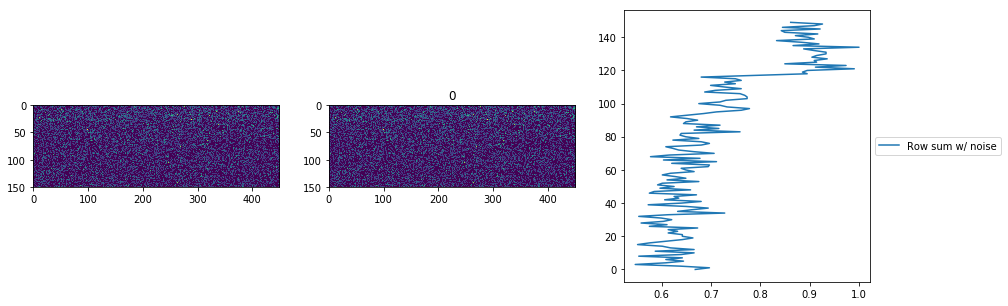

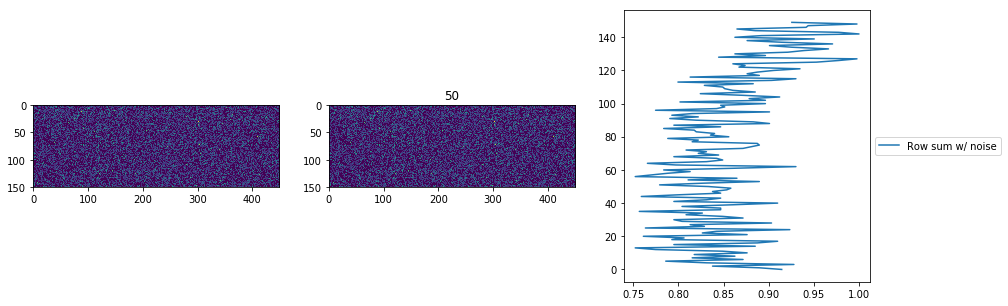

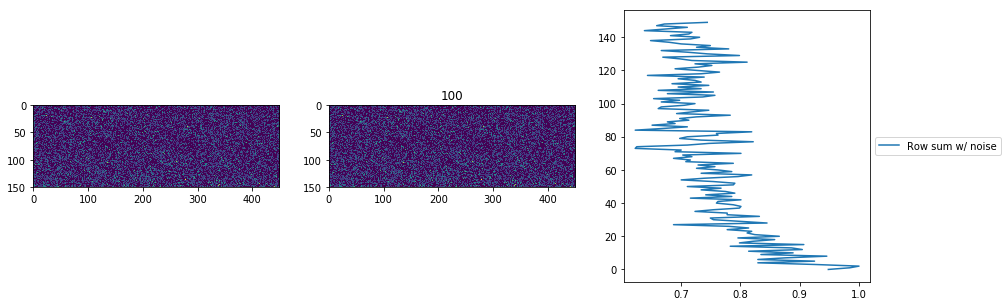

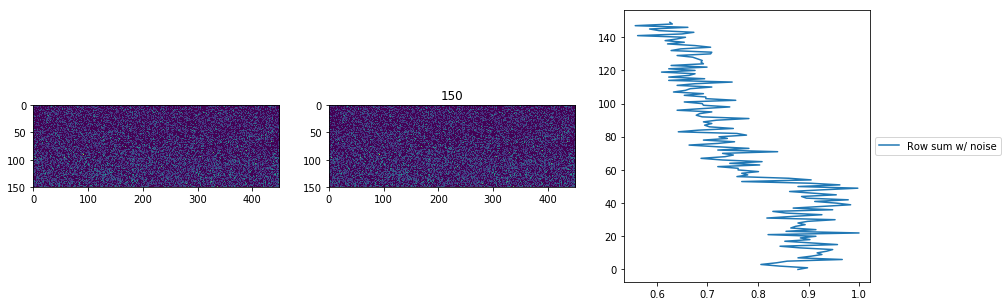

436.0


In [9]:
DC_even = []
SYM_even= []
DC_odd = []
SYM_odd = []
DC_all = []
SYM_all = []
j = iter(list(range(50)))


shifting_range = 200#sinogram.shape[0]-200
for i in range(shifting_range):
    #shift sinogram so rotation center is off of image center and add noise
    #sinogram_shift_noiseless = np.clip(np.zeros((int(sinogram.shape[0]*2-256),sinogram.shape[1])),clip,None)
    #sinogram_shift_noiseless[100:100+sinogram.shape[0],:] = sinogram

    #sinogram_shift = add_noise(sinogram_shift_noiseless, exposure, bit_depth = 8)[0][i:i+450,:]
    sinogram_shift = add_noise(sinogram[i:i+150,:], exposure)[0]
    
    #Sum sinogram along rows.
    #rowsum = np.sum(sinogram_shift_noiseless, axis=1, dtype=np.float64)
    rowsum_noise = np.sum(sinogram_shift, axis=1, dtype=np.float64)
    
    
    #Extract DC and SYM frequencies
    DC, SYM = DC_and_SYM(rowsum_noise)
    
    DC_all.append(DC)
    SYM_all.append(SYM)
    #Extract even and odd parts of DC and SYM.
    DC_even.append(np.real(DC))
    SYM_even.append(np.real(SYM))
    DC_odd.append(np.imag(DC))
    SYM_odd.append(np.imag(SYM))

    #Plotting
    if i %50==0:
        a = next(j)
        plt.figure(figsize=(15,5))
        plt.subplot(131)
        plt.imshow(sinogram_shift)
        plt.subplot(132)
        plt.imshow(sinogram_shift)
        plt.title(str(a*50))
        plt.subplot(133)
        #plt.plot((rowsum/np.max(rowsum))[::-1], np.arange(0,sinogram_shift.shape[0],1), label = 'Row sum w/o noise')
        plt.plot((rowsum_noise/np.max(rowsum_noise))[::-1], np.arange(0,sinogram_shift.shape[0],1), label = 'Row sum w/ noise')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        #plt.title('Entropy = ' + str(entropy)[0:10])
        plt.show()
    
plt.show()
print(np.max(rowsum_noise))


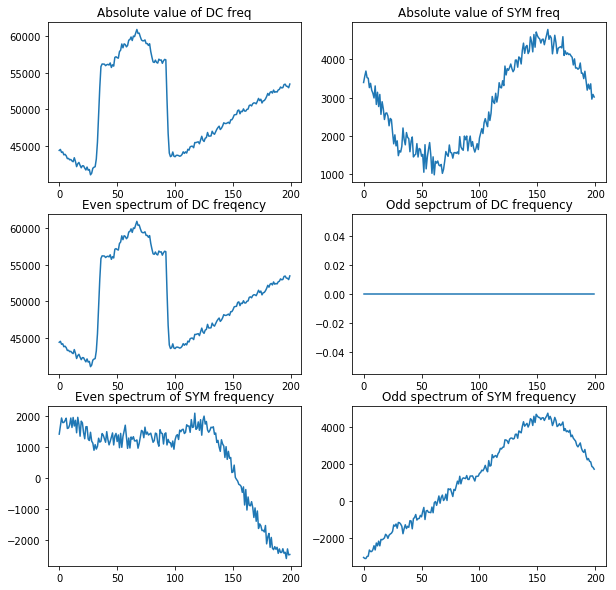

int64 6 0


In [5]:
plt.figure(figsize=(10,10))
plt.subplot(321)
plt.plot(np.abs(DC_all))
plt.title('Absolute value of DC freq')
plt.subplot(322)
plt.plot(np.abs(SYM_all))
plt.title('Absolute value of SYM freq')
plt.subplot(323)
plt.title('Even spectrum of DC freqency')
plt.plot(DC_even)
plt.subplot(324)
plt.title('Odd sepctrum of DC frequency')
plt.plot(DC_odd)

plt.subplot(325)
plt.title('Even spectrum of SYM frequency')
plt.plot(SYM_even)
plt.subplot(326)
plt.title('Odd spectrum of SYM frequency')
plt.plot(SYM_odd)

plt.show()

print(sinogram_shift.dtype, np.max(sinogram_shift), np.min(sinogram_shift))

# Fit odd imag component to sine curve

/raid/home/everett/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


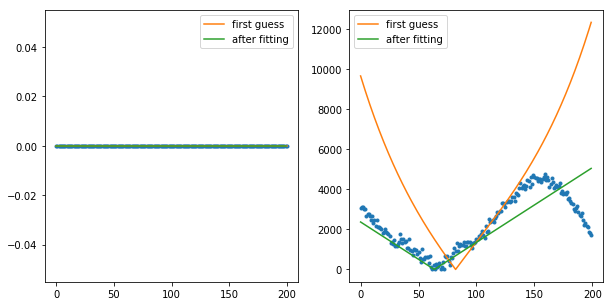

In [6]:
N = len(DC_odd) # number of data points
t = np.linspace(0, N, N)
#f = None # Optional!! Advised not to use
data = np.asarray(DC_odd) # create artificial data with noise
data_linear = np.asarray(SYM_odd)

guess_mean = np.mean(data)
guess_std = np.std(data)
guess_phase = -np.pi/2
guess_freq = np.pi/(N)
guess_amp = np.max(data)

guess_mean2 = np.mean(data_linear)
guess_std2 = np.std(data_linear)
guess_phase2 = -np.pi/2
guess_freq2 = np.pi/(N)
guess_amp2 = np.max(data_linear)

# we'll use this to plot our first estimate. This might already be good enough for you
data_first_guess = guess_std*np.sin(guess_freq*t+guess_phase) + guess_mean

# Define the function to optimize, in this case, we want to minimize the difference
# between the actual data and our "guessed" parameters
optimize_func = lambda x: x[0]*np.cosh(x[1]*t+x[2]) + x[3] - data
est_amp, est_freq, est_phase, est_mean= leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

# recreate the fitted curve using the optimized parameters
data_linear = np.asarray(SYM_odd)
guess_slope = 10
guess_intercept = -4
s = t
optimize_linear = lambda y: y[0]*np.sinh(y[1]*s + y[2]) - data_linear
est_amp2, est_freq2, est_phase2 = leastsq(optimize_linear, [guess_amp2, guess_freq2, guess_phase2])[0]

# recreate the fitted curve using the optimized parameters

fine_t = np.arange(0,N,1)
data_fit=est_amp*np.cosh(est_freq*fine_t+est_phase)+est_mean

data_fit_linear = est_amp2*np.sinh(est_freq2*s+ est_phase2)
data_first_guess_linear = guess_amp2*np.sinh(guess_freq2*s+ guess_phase2)+ guess_mean2

plt.figure(figsize = (10,5))
plt.subplot(121)
plt.plot(t, data, '.')
plt.plot(t, data_first_guess, label='first guess')
plt.plot(fine_t, data_fit, label='after fitting')
plt.legend()

plt.subplot(122)
plt.plot(np.abs(data_linear), '.')
plt.plot(np.abs(data_first_guess_linear), label='first guess')
plt.plot(fine_t, np.abs(data_fit_linear), label='after fitting')
plt.legend()

plt.show()

In [7]:
x_range = np.linspace(0,N, 1)
fit = est_amp*np.sin(est_freq*x_range+est_phase)+est_mean


fft_odd_max = argrelextrema(abs(data_fit), np.greater)[0]
fft_odd_imag_min = argrelextrema(abs(data_fit_linear), np.less)[0]

print('True Center: ', sinogram.shape[0]/2+ 100)
print('Odd real minimum: ', sinogram_shift.shape[0]/2 + fft_odd_max)
print('Odd imag minimum: ', sinogram_shift.shape[0]/2 + fft_odd_imag_min)

True Center:  275.0
Odd real minimum:  []
Odd imag minimum:  [139.]


In [16]:
y = np.load('rowsum.npy')[::-1]
x = np.linspace(0,len(y),len(y))
ffty = np.fft.fft(y)

odd_comp = np.zeros(ffty.shape)+0.j
even_comp = np.real(ffty)
#odd_comp = np.imag(ffty)
odd_comp[1] = ffty[1]


plt.axvline(x=350, color='black', linewidth=1)
plt.axhline(y=0, color = 'black', linewidth=1)
plt.plot(y, label = 'Feature')
plt.plot(np.real(np.fft.ifft(even_comp)), label = 'Even Component')
plt.plot(-np.imag(np.fft.ifft(odd_comp)), label = 'Odd Component')
plt.yticks([])
plt.xticks([])
#plt.legend()
plt.show()



'''
x = np.linspace(-1,len(y/2),len(y/2))
ffty = np.fft.fft(y[0:int(len(y)/2)])

even_comp = np.real(ffty)
odd_comp = np.imag(ffty)

feature = y[0:int(len(y)/2)]

plt.plot(feature, label = 'Feature')
plt.plot(np.real(np.fft.ifft(even_comp)), label = 'Even Component')
plt.plot(-np.imag(np.fft.ifft(odd_comp)), label = 'Odd Component')
plt.legend()
plt.show()
'''

FileNotFoundError: [Errno 2] No such file or directory: 'rowsum.npy'

In [11]:
print(np.sum(odd_comp))
print(odd_comp)

(103449.42766339575+40928018.14393303j)
[     0.              +0.j         103449.4276634+40928018.14393303j
      0.              +0.j         ...      0.              +0.j
      0.              +0.j              0.              +0.j        ]


/home/everett/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


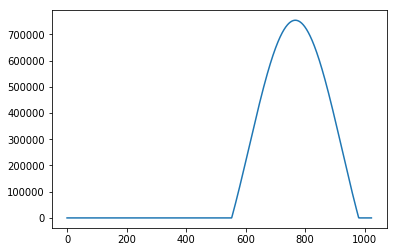

In [12]:
plt.plot(np.fft.ifft(ffty[:]))
plt.show()

In [13]:
np.fft.ifft((103449.42766339575+40928018.14393303j,))

array([103449.4276634+40928018.14393303j])